<a href="https://colab.research.google.com/github/klotardesignstudio/tradebao-cripto-poc/blob/main/02_Backtest_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install --upgrade pandas-ta

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Backtest da Estratégia de Força Relativa

Dados de adabtc carregados com sucesso. Período de 2022-12-02 a 2025-08-27

--- RESULTADOS DO BACKTEST (COM FILTRO DE TENDÊNCIA) para adabtc ---
Ativo Analisado: adabtc
Capital Inicial: 1.0000 BTC
Capital Final: 1.2648 BTC
Número de Trades: 8
Rentabilidade da Estratégia: 26.48%
Rentabilidade do Benchmark (Buy and Hold adabtc): -48.66%

Resultado: ✅ A ESTRATÉGIA SUPEROU O BENCHMARK!


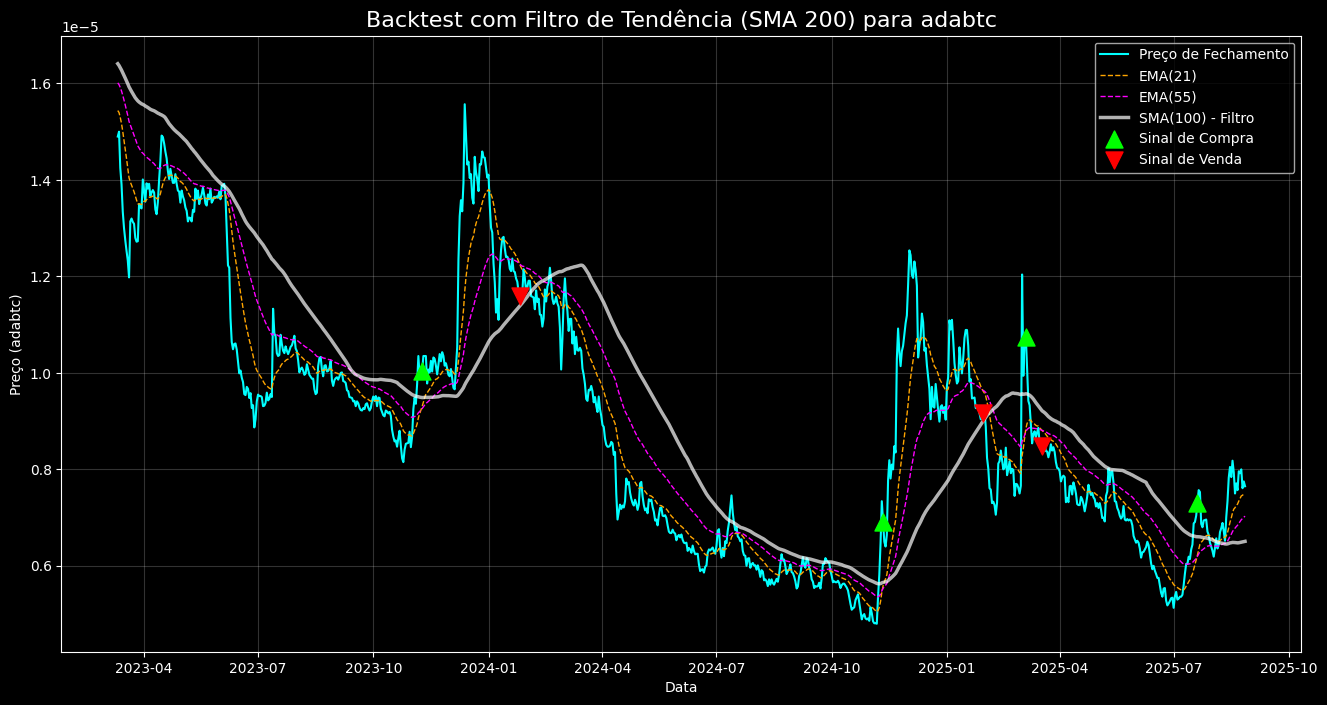

Dados de ethbtc carregados com sucesso. Período de 2022-12-02 a 2025-08-27

--- RESULTADOS DO BACKTEST (COM FILTRO DE TENDÊNCIA) para ethbtc ---
Ativo Analisado: ethbtc
Capital Inicial: 1.0000 BTC
Capital Final: 1.0563 BTC
Número de Trades: 14
Rentabilidade da Estratégia: 5.63%
Rentabilidade do Benchmark (Buy and Hold ethbtc): -43.72%

Resultado: ✅ A ESTRATÉGIA SUPEROU O BENCHMARK!


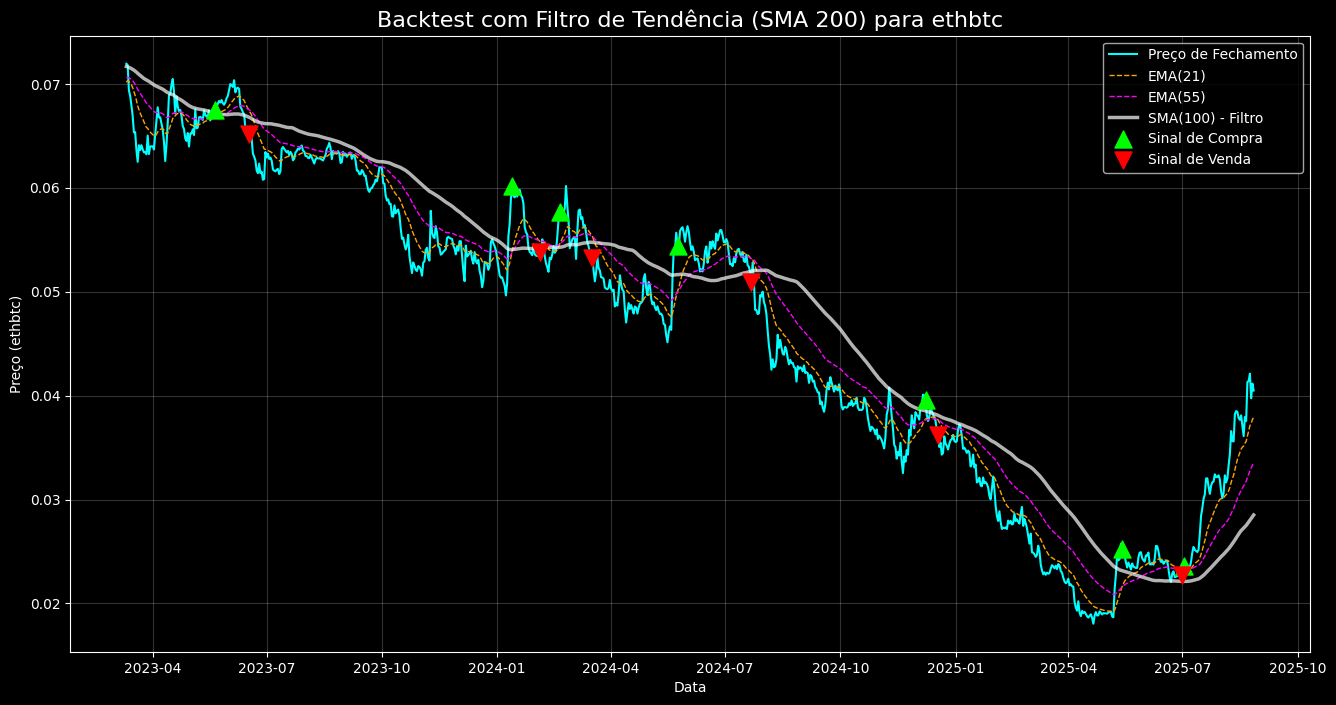

Dados de linkbtc carregados com sucesso. Período de 2022-12-02 a 2025-08-27

--- RESULTADOS DO BACKTEST (COM FILTRO DE TENDÊNCIA) para linkbtc ---
Ativo Analisado: linkbtc
Capital Inicial: 1.0000 BTC
Capital Final: 1.0963 BTC
Número de Trades: 12
Rentabilidade da Estratégia: 9.63%
Rentabilidade do Benchmark (Buy and Hold linkbtc): -29.03%

Resultado: ✅ A ESTRATÉGIA SUPEROU O BENCHMARK!


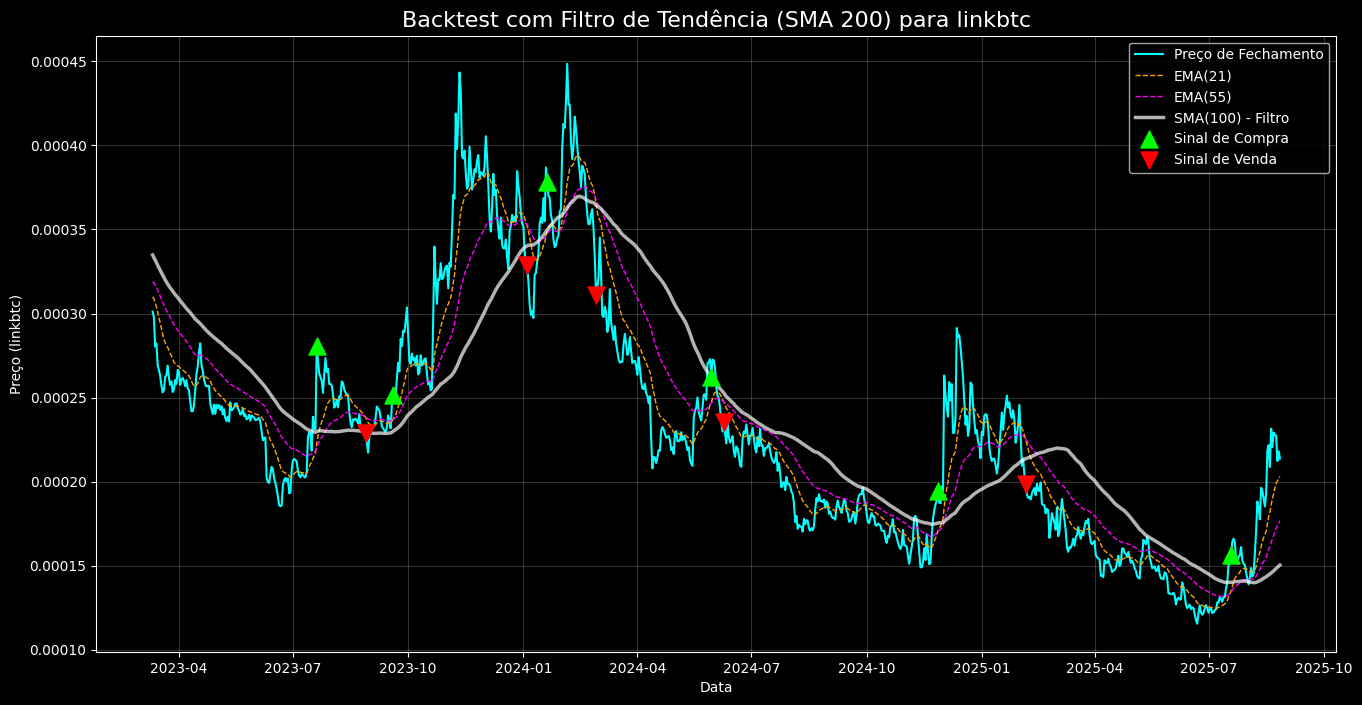

Dados de solbtc carregados com sucesso. Período de 2022-12-02 a 2025-08-27

--- RESULTADOS DO BACKTEST (COM FILTRO DE TENDÊNCIA) para solbtc ---
Ativo Analisado: solbtc
Capital Inicial: 1.0000 BTC
Capital Final: 1.1373 BTC
Número de Trades: 18
Rentabilidade da Estratégia: 13.73%
Rentabilidade do Benchmark (Buy and Hold solbtc): 107.01%

Resultado: ❌ A ESTRATÉGIA NÃO SUPEROU O BENCHMARK.


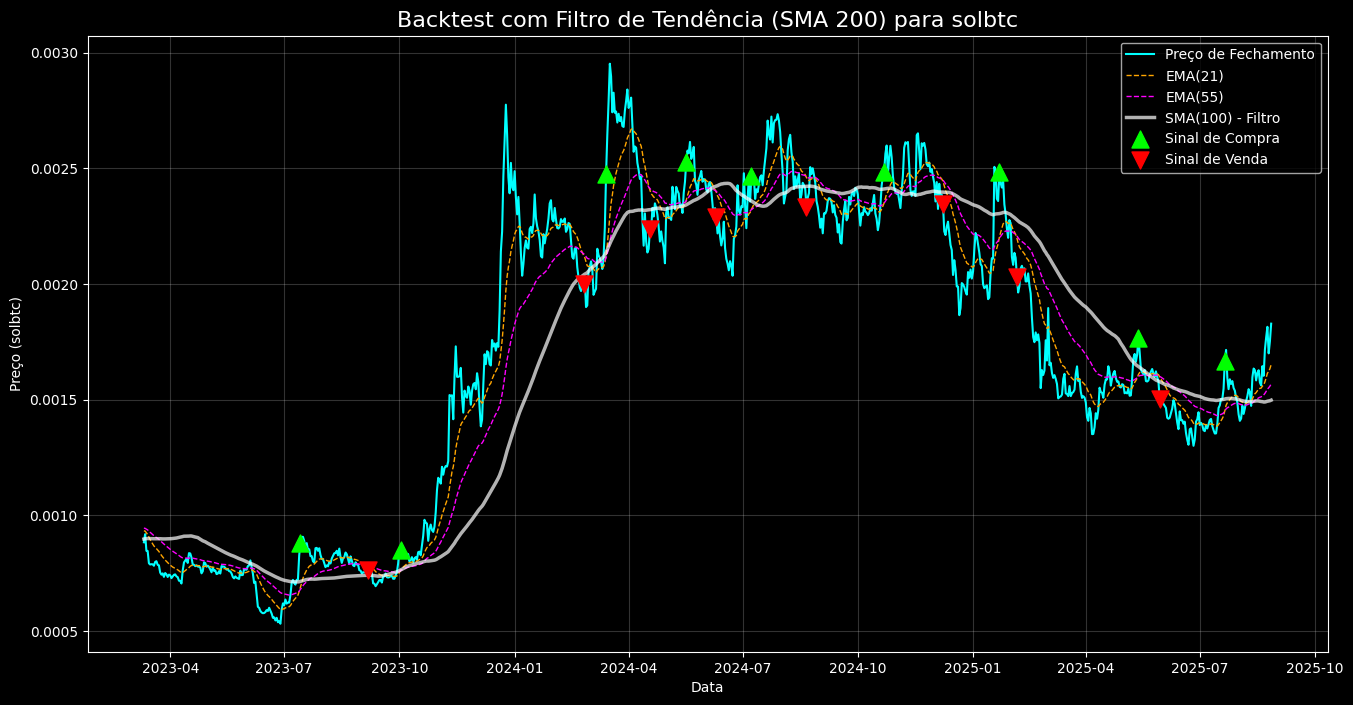

Dados de xrpbtc carregados com sucesso. Período de 2022-12-02 a 2025-08-27

--- RESULTADOS DO BACKTEST (COM FILTRO DE TENDÊNCIA) para xrpbtc ---
Ativo Analisado: xrpbtc
Capital Inicial: 1.0000 BTC
Capital Final: 1.6283 BTC
Número de Trades: 12
Rentabilidade da Estratégia: 62.83%
Rentabilidade do Benchmark (Buy and Hold xrpbtc): 50.00%

Resultado: ✅ A ESTRATÉGIA SUPEROU O BENCHMARK!


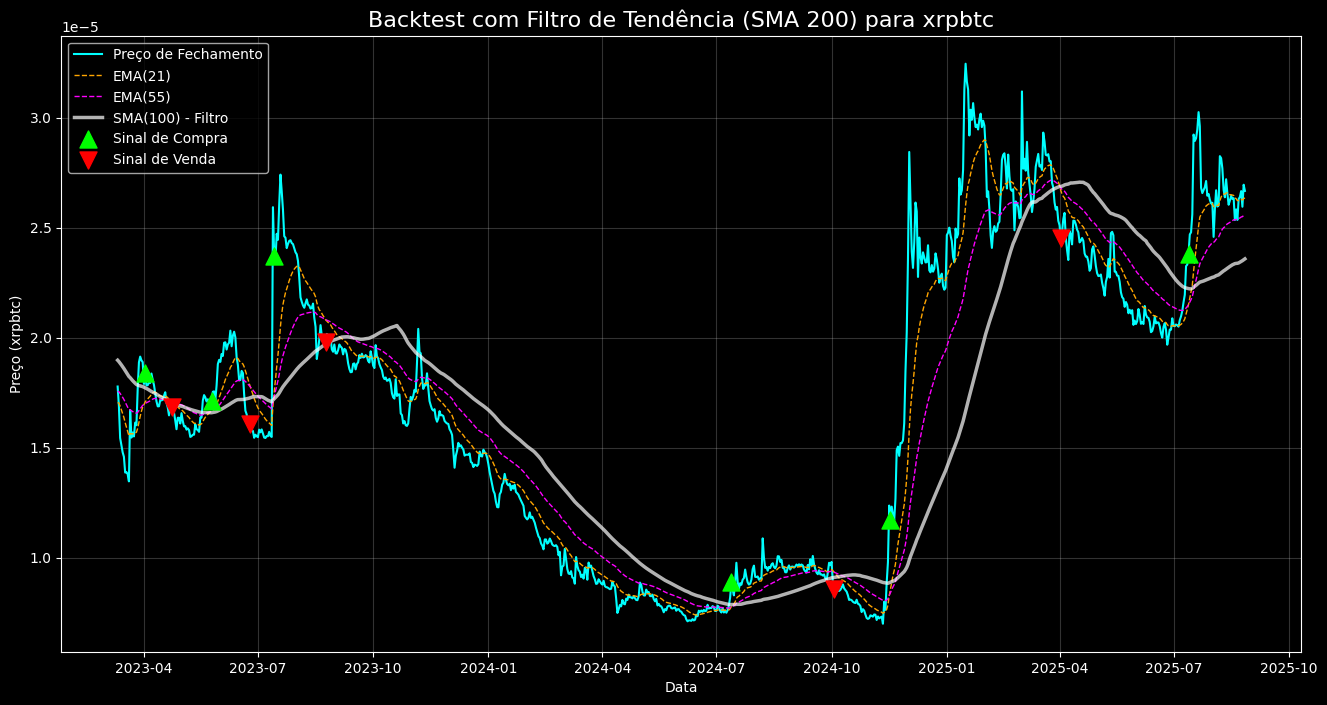

In [33]:
# ==============================================================================
# TRADEBAO POC - NOTEBOOK 02: BACKTEST STRATEGY (V3 - CORREÇÃO FINAL)
# ==============================================================================

# 0. Importando as bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- CONFIGURAÇÕES DO BACKTEST ---
simbolos = ["adabtc", "ethbtc", "linkbtc", "solbtc", "xrpbtc"]

# Parâmetros da Estratégia de Entrada/Saída
ema_curta_periodo = 21
ema_longa_periodo = 55

# --- NOVIDADE: Parâmetro do Filtro de Tendência ---
sma_tendencia_periodo = 100

capital_inicial_btc = 1.0
# ---------------------------------

for simbolo in simbolos:
    caminho_do_arquivo = f'/content/drive/MyDrive/Colab Notebooks/TradeBaoCripto/dados_binance_{simbolo}.csv'

    # 1. Carregar os Dados do Google Drive
    try:
        df = pd.read_csv(caminho_do_arquivo, index_col='Open Time', parse_dates=True)
        print(f"Dados de {simbolo} carregados com sucesso. Período de {df.index.min().date()} a {df.index.max().date()}")
    except FileNotFoundError:
        print(f"ERRO: Arquivo não encontrado em '{caminho_do_arquivo}'. Verifique o caminho e o nome do arquivo para {simbolo}.")
        continue # Pula para o próximo símbolo se o arquivo não for encontrado

    # 2. Implementar a Lógica (O Motor)
    ema_curta_nome = f'EMA_{ema_curta_periodo}'
    ema_longa_nome = f'EMA_{ema_longa_periodo}'
    df[ema_curta_nome] = df['Close'].ewm(span=ema_curta_periodo, adjust=False).mean()
    df[ema_longa_nome] = df['Close'].ewm(span=ema_longa_periodo, adjust=False).mean()

    # --- NOVIDADE: Cálculo do Filtro de Tendência (SMA 200) ---
    # Usando a função .rolling() do pandas para calcular a Média Móvel Simples
    sma_tendencia_nome = f'SMA_{sma_tendencia_periodo}'
    df[sma_tendencia_nome] = df['Close'].rolling(window=sma_tendencia_periodo).mean()

    # Remove as linhas iniciais que não têm dados suficientes para os cálculos
    df.dropna(inplace=True)

    # 3. Gerar os Sinais de Trade
    # --- LÓGICA ALTERADA: Adicionando o filtro de tendência ---
    filtro_tendencia_positiva = df['Close'] > df[sma_tendencia_nome]

    # O sinal de compra AGORA SÓ ACONTECE se o cruzamento ocorrer E o preço estiver acima da SMA 200
    df['sinal_compra'] = (df[ema_curta_nome] > df[ema_longa_nome]) & (df[ema_curta_nome].shift(1) < df[ema_longa_nome].shift(1)) & filtro_tendencia_positiva

    # O sinal de venda permanece o mesmo: saímos da posição quando as médias se cruzam para baixo
    df['sinal_venda'] = (df[ema_curta_nome] < df[ema_longa_nome]) & (df[ema_curta_nome].shift(1) > df[ema_longa_nome].shift(1))

    # 4. Executar o Backtest (código permanece o mesmo)
    capital_final_btc = capital_inicial_btc
    capital_altcoin = 0.0
    em_posicao = False
    trades = []

    for i, row in df.iterrows():
        if row['sinal_compra'] and not em_posicao:
            capital_altcoin = capital_final_btc / row['Close']
            capital_final_btc = 0.0
            em_posicao = True
            trades.append({'data': i, 'tipo': 'COMPRA', 'preco': row['Close'], 'qtd_altcoin': capital_altcoin})

        elif row['sinal_venda'] and em_posicao:
            capital_final_btc = capital_altcoin * row['Close']
            capital_altcoin = 0.0
            em_posicao = False
            trades.append({'data': i, 'tipo': 'VENDA', 'preco': row['Close'], 'capital_btc': capital_final_btc})

    if em_posicao:
        capital_final_btc = capital_altcoin * df['Close'].iloc[-1]
        trades.append({'data': df.index[-1], 'tipo': 'VENDA FORÇADA', 'preco': df['Close'].iloc[-1], 'capital_btc': capital_final_btc})

    # 5. Calcular e Exibir os Resultados (código permanece o mesmo)
    rentabilidade_estrategia = ((capital_final_btc - capital_inicial_btc) / capital_inicial_btc) * 100
    # Para o benchmark, vamos calcular a rentabilidade do buy and hold para o ativo específico
    if not df.empty:
        rentabilidade_buy_and_hold = ((df['Close'].iloc[-1] - df['Close'].iloc[0]) / df['Close'].iloc[0]) * 100
    else:
        rentabilidade_buy_and_hold = 0

    num_trades = len(trades)

    print(f"\n--- RESULTADOS DO BACKTEST (COM FILTRO DE TENDÊNCIA) para {simbolo} ---")
    print(f"Ativo Analisado: {simbolo}")
    print(f"Capital Inicial: {capital_inicial_btc:.4f} BTC")
    print(f"Capital Final: {capital_final_btc:.4f} BTC")
    print(f"Número de Trades: {num_trades}")
    print(f"Rentabilidade da Estratégia: {rentabilidade_estrategia:.2f}%")
    print(f"Rentabilidade do Benchmark (Buy and Hold {simbolo}): {rentabilidade_buy_and_hold:.2f}%")

    if rentabilidade_estrategia > rentabilidade_buy_and_hold:
        print("\nResultado: ✅ A ESTRATÉGIA SUPEROU O BENCHMARK!")
    else:
        print("\nResultado: ❌ A ESTRATÉGIA NÃO SUPEROU O BENCHMARK.")

    # 6. Visualizar os Resultados
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(16, 8))

    # Plotando preços e médias
    ax.plot(df.index, df['Close'], label='Preço de Fechamento', color='cyan', linewidth=1.5)
    ax.plot(df.index, df[ema_curta_nome], label=f'EMA({ema_curta_periodo})', color='orange', linestyle='--', linewidth=1)
    ax.plot(df.index, df[ema_longa_nome], label=f'EMA({ema_longa_periodo})', color='magenta', linestyle='--', linewidth=1)

    # --- NOVIDADE: Plotando o Filtro de Tendência ---
    ax.plot(df.index, df[sma_tendencia_nome], label=f'SMA({sma_tendencia_periodo}) - Filtro', color='white', linewidth=2.5, alpha=0.7)

    # Plotando os sinais de compra e venda (que agora são filtrados)
    sinais_compra_df = df[df['sinal_compra']]
    ax.scatter(sinais_compra_df.index, sinais_compra_df['Close'], marker='^', color='lime', s=150, label='Sinal de Compra', zorder=5)

    sinais_venda_df = df[df['sinal_venda']]
    ax.scatter(sinais_venda_df.index, sinais_venda_df['Close'], marker='v', color='red', s=150, label='Sinal de Venda', zorder=5)

    ax.set_title(f'Backtest com Filtro de Tendência (SMA 200) para {simbolo}', fontsize=16)
    ax.set_ylabel(f'Preço ({simbolo})')
    ax.set_xlabel('Data')
    ax.legend()
    ax.grid(alpha=0.2)
    plt.show()